In [1]:
import numpy as np
import scipy as sc
import xarray as xr
import matplotlib.pyplot as plt
from eofs.standard import Eof
import cartopy.crs as ccrs
import cartopy.crs as ccrs
import cartopy
import matplotlib as mpl
import scipy as sc
import cartopy.feature
import matplotlib.path as mpath
from cartopy import feature
import cmocean as cm
from dask.distributed import Client

from cartopy.util import add_cyclic_point as cycpt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from sklearn.preprocessing import normalize
import datetime
import cosima_cookbook as cc


In [2]:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46841/status,
Dashboard: /proxy/46841/status,Workers: 28
Total threads: 56,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35491,Workers: 28
Dashboard: /proxy/46841/status,Total threads: 56
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:42629,Total threads: 2
Dashboard: /proxy/38365/status,Memory: 6.73 GiB
Nanny: tcp://127.0.0.1:38295,


In [3]:
ls /g/data/oz91/ma3822/access-om2/archive/01deg_jra55_ryf_ZW3PC1Plus/ZW3PC1Plus.db

/g/data/oz91/ma3822/access-om2/archive/01deg_jra55_ryf_ZW3PC1Plus/ZW3PC1Plus.db


In [4]:
databases = ['/scratch/jk72/ma3822/access-om2/archive/01deg_jra55_9091ryf/01deg_jra55_9091ryf.db',
             '/g/data/oz91/ma3822/access-om2/archive/01deg_jra55_ryf_ZW3PC1Plus/ZW3PC1Plus.db',
             '/g/data/oz91/ma3822/access-om2/archive/01deg_jra55_ryf_ZW3PC1Minus/ZW3PC1Minus.db',
             '/scratch/jk72/ma3822/access-om2/archive/01deg_jra55_ryf_ZW3PC2Plus/ZW3PC2Plus.db',
             '/g/data/oz91/ma3822/access-om2/archive/01deg_jra55_ryf_ZW3PC2Minus/ZW3PC2Minus.db']


names = ['Neutral', 'PC1Plus', 'PC1Minus', 'PC2Plus', 'PC2Minus']


expts = ['01deg_jra55_9091ryf', '01deg_jra55_ryf_ZW3PC1Plus','01deg_jra55_ryf_ZW3PC1Minus','01deg_jra55_ryf_ZW3PC2Plus','01deg_jra55_ryf_ZW3PC2Minus']


sessions = [cc.database.create_session(database) for database in databases]

In [5]:
m = 1
start_time = '2179-%02d-01' %m
end_time   = '2181-%02d-01' %(m)

In [6]:
tau_x = cc.querying.getvar(expts[1],'tau_x',sessions[1], frequency = '1 monthly').sel(time=slice(start_time,end_time))
tau_x

<xarray.DataArray 'tau_x' (time: 12, yu_ocean: 2700, xu_ocean: 3600)>
dask.array<getitem, shape=(12, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2180-01-16 12:00:00 ... 2180-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  surface_downward_x_stress
    ncfiles:        ['/g/data/oz91/ma3822/access-om2/archive/01deg_jra55_ryf_...

In [7]:
def import_sis(expts,sessions,i,var,start_time = start_time,end_time = end_time):
    sis = cc.querying.getvar(expts[i], "aice_m", sessions[i], frequency='1 monthly',end_time=end_time, compat="override", coords="minimal")
    sis	= sis.rename({'nj':'yu_ocean', 'ni':'xu_ocean'})
    sis.coords['xu_ocean'] = var.xu_ocean
    sis.coords['yu_ocean'] = var.yu_ocean
    sis = sis.sel(yu_ocean = slice(-90,-50))
    # sis = sis.resample(time="1M").mean()
    return(sis)

In [8]:
def import_hi(expts,sessions,i,var,start_time = start_time,end_time = end_time):
    sis = cc.querying.getvar(expts[i], "hi", sessions[i], frequency='1 daily',start_time = start_time,end_time=end_time, compat="override", coords="minimal")
    sis	= sis.rename({'nj':'yu_ocean', 'ni':'xu_ocean'})
    sis.coords['xu_ocean'] = var.xu_ocean
    sis.coords['yu_ocean'] = var.yu_ocean
    sis = sis.sel(yu_ocean = slice(-90,-50))
    # sis = sis.resample(time="1M").mean()
    return(sis)

In [9]:
def import_hi_monthly(expts,sessions,i,var,start_time = start_time,end_time = end_time):
    sis = cc.querying.getvar(expts[i], "hi_m", sessions[i], frequency='1 monthly',end_time=end_time, compat="override", coords="minimal")
    sis	= sis.rename({'nj':'yu_ocean', 'ni':'xu_ocean'})
    sis.coords['xu_ocean'] = var.xu_ocean
    sis.coords['yu_ocean'] = var.yu_ocean
    sis = sis.sel(yu_ocean = slice(-90,-50))
    # sis = sis.resample(time="1M").mean()
    return(sis)

In [10]:
def import_uvel_monthly(expts,sessions,i,var,start_time = start_time,end_time = end_time):
    sis = cc.querying.getvar(expts[i], "uvel_m", sessions[i], frequency='1 monthly',end_time=end_time, compat="override", coords="minimal")
    sis	= sis.rename({'nj':'yu_ocean', 'ni':'xu_ocean'})
    sis.coords['xu_ocean'] = var.xu_ocean
    sis.coords['yu_ocean'] = var.yu_ocean
    sis = sis.sel(yu_ocean = slice(-90,-50))
    # sis = sis.resample(time="1M").mean()
    return(sis)

In [11]:
def import_vvel_monthly(expts,sessions,i,var,start_time = start_time,end_time = end_time):
    sis = cc.querying.getvar(expts[i], "vvel_m", sessions[i], frequency='1 monthly',end_time=end_time, compat="override", coords="minimal")
    sis	= sis.rename({'nj':'yu_ocean', 'ni':'xu_ocean'})
    sis.coords['xu_ocean'] = var.xu_ocean
    sis.coords['yu_ocean'] = var.yu_ocean
    sis = sis.sel(yu_ocean = slice(-90,-50))
    # sis = sis.resample(time="1M").mean()
    return(sis)

In [12]:
def import_frazil(expts,sessions,i,var,start_time = start_time,end_time = end_time):
    sis = cc.querying.getvar(expts[i], "frazil_m", sessions[i], frequency='1 monthly',end_time=end_time, compat="override", coords="minimal")
    sis	= sis.rename({'nj':'yu_ocean', 'ni':'xu_ocean'})
    sis.coords['xu_ocean'] = var.xu_ocean
    sis.coords['yu_ocean'] = var.yu_ocean
    sis = sis.sel(yu_ocean = slice(-90,-50))
    # sis = sis.resample(time="1M").mean()
    return(sis)


In [13]:
def import_congel(expts,sessions,i,var,start_time = start_time,end_time = end_time):
    sis = cc.querying.getvar(expts[i], "congel_m", sessions[i], frequency='1 monthly',end_time=end_time, compat="override", coords="minimal")
    sis	= sis.rename({'nj':'yu_ocean', 'ni':'xu_ocean'})
    sis.coords['xu_ocean'] = var.xu_ocean
    sis.coords['yu_ocean'] = var.yu_ocean
    sis = sis.sel(yu_ocean = slice(-90,-50))
    # sis = sis.resample(time="1M").mean()
    return(sis)

In [14]:
%time
frazil_ar = [import_frazil(expts,sessions,i,tau_x) for i in range(len(expts))]

CPU times: user 2 µs, sys: 5 µs, total: 7 µs
Wall time: 16.5 µs


In [15]:
%time
congel_ar = [import_congel(expts,sessions,i,tau_x) for i in range(len(expts))]

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 7.87 µs


In [16]:
area = cc.querying.getvar(expt=expts[0], variable='area_u', 
                          session=sessions[0], frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1)
area = area.sel(yu_ocean = slice(-90,-50))

In [17]:
%time
aice_ar = [import_sis(expts,sessions,i,tau_x) for i in range(len(expts))]

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 12.9 µs


In [18]:
area = cc.querying.getvar(expt=expts[0], variable='area_u', 
                          session=sessions[0], frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1)
area = area.sel(yu_ocean = slice(-90,-50))

In [19]:
hu = cc.querying.getvar(expt=expts[0], variable='hu', 
                          session=sessions[0], frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1)
hu = hu.sel(yu_ocean = slice(-90,-50))

In [20]:
%time
uvel_ar = [import_uvel_monthly(expts,sessions,i,tau_x) for i in range(len(expts))]
vvel_ar = [import_vvel_monthly(expts,sessions,i,tau_x) for i in range(len(expts))]


CPU times: user 3 µs, sys: 5 µs, total: 8 µs
Wall time: 13.4 µs


In [21]:
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20) 

In [22]:
frazil_ar

[<xarray.DataArray 'frazil_m' (time: 12, yu_ocean: 665, xu_ocean: 3600)>
 dask.array<getitem, shape=(12, 665, 3600), dtype=float32, chunksize=(1, 665, 900), chunktype=numpy.ndarray>
 Coordinates:
   * time      (time) object 2180-02-01 00:00:00 ... 2181-01-01 00:00:00
     TLON      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(665, 900), meta=np.ndarray>
     TLAT      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(665, 900), meta=np.ndarray>
     ULON      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(665, 900), meta=np.ndarray>
     ULAT      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(665, 900), meta=np.ndarray>
   * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
   * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -50.19 -50.12 -50.06
 Attributes:
     units:          cm/day
     long_name:      frazil ice growth
     cell_measures:  area: tarea
     cell_methods:   time: mean
     time_rep:       averaged
     ncfiles:       

In [23]:
xr.concat(frazil_ar, 'scenario')

<xarray.DataArray 'frazil_m' (scenario: 5, time: 12, yu_ocean: 665,
                              xu_ocean: 3600)>
dask.array<concatenate, shape=(5, 12, 665, 3600), dtype=float32, chunksize=(1, 1, 665, 900), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2180-02-01 00:00:00 ... 2181-01-01 00:00:00
    TLON      (yu_ocean, xu_ocean) float32 nan nan nan nan ... 79.75 79.85 79.95
    TLAT      (yu_ocean, xu_ocean) float32 nan nan nan ... -50.09 -50.09 -50.09
    ULON      (yu_ocean, xu_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    ULAT      (yu_ocean, xu_ocean) float32 nan nan nan ... -50.06 -50.06 -50.06
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -50.19 -50.12 -50.06
Dimensions without coordinates: scenario
Attributes:
    units:          cm/day
    long_name:      frazil ice growth
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/scratch/jk72/ma3822/access-om2/archive/01deg_jra55_909...

In [24]:
uvel_coarsen = [uvel.coarsen(xu_ocean = 25, yu_ocean = 12, boundary='trim').mean()[0:12] for uvel in uvel_ar]
vvel_coarsen = [vvel.coarsen(xu_ocean = 25, yu_ocean = 12, boundary='trim').mean()[0:12] for vvel in vvel_ar]


In [25]:
frazil = xr.concat(frazil_ar, 'scenario')
congel = xr.concat(congel_ar, 'scenario')
aice = xr.concat(aice_ar, 'scenario')
da_uvel_coarsen = xr.concat(uvel_coarsen, 'scenario')
da_vvel_coarsen = xr.concat(vvel_coarsen, 'scenario')
frazil["scenario"] = names
congel["scenario"] = names
da_uvel_coarsen["scenario"] = names
da_vvel_coarsen["scenario"] = names
aice["scenario"] = names

frazil.to_netcdf("/g/data/oz91/ma3822/ZW3/data/frazil.nc")
congel.to_netcdf("/g/data/oz91/ma3822/ZW3/data/congel.nc")
aice.to_netcdf("/g/data/oz91/ma3822/ZW3/data/aice.nc")
da_uvel_coarsen.to_netcdf("/g/data/oz91/ma3822/ZW3/data/uvel_coarsen.nc")
da_vvel_coarsen.to_netcdf("/g/data/oz91/ma3822/ZW3/data/vvel_coarsen.nc")


In [31]:
da_obs = xr.open_dataset("/g/data/oz91/ma3822/ZW3/data/obs_SIdrift_regressed.nc")
da_obs

<xarray.Dataset>
Dimensions:               (month: 12, y: 321, x: 321)
Coordinates:
  * x                     (x) float64 -4.011e+06 -3.986e+06 ... 4.011e+06
  * y                     (y) float64 -4.011e+06 -3.986e+06 ... 4.011e+06
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    regressed_driftx_PC1  (month, y, x) float64 ...
    regressed_driftx_PC2  (month, y, x) float64 ...
    regressed_drifty_PC1  (month, y, x) float64 ...
    regressed_drifty_PC2  (month, y, x) float64 ...
    lon                   (y, x) float32 ...
    lat                   (y, x) float32 ...

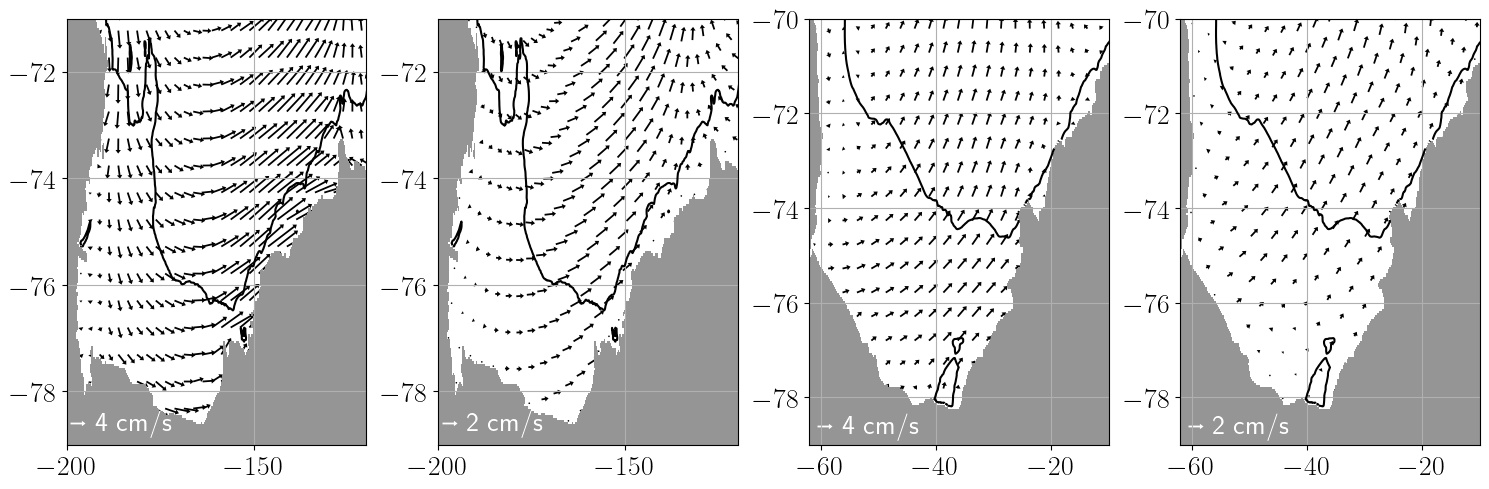

In [56]:


f, axes = plt.subplots(1, 4, figsize=(15, 5))

# Panel 0: Scenario 1 vs Control (Weddell Sea region)
ax = axes[0]

# Note: Using first scenario data for grid coordinates
u_diff_1 = (da_uvel_coarsen.isel(time = slice(2,9)).sel(scenario=names[1]).mean("time") - 
            da_uvel_coarsen.isel(time = slice(2,9)).sel(scenario=names[0]).mean("time"))
v_diff_1 = (da_vvel_coarsen.isel(time = slice(2,9)).sel(scenario=names[1]).mean("time") - 
            da_vvel_coarsen.isel(time = slice(2,9)).sel(scenario=names[0]).mean("time"))

Q = ax.quiver(da_vvel_coarsen.sel(scenario=names[0]).xu_ocean, 
              da_vvel_coarsen.sel(scenario=names[0]).yu_ocean,
              u_diff_1, v_diff_1,
              scale=0.8, width=0.006, headwidth=3, headlength=2, headaxislength=2)

# Add land and bathymetry
land = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land.plot(ax=ax, add_colorbar=False, cmap="Greys")
hu.plot.contour(ax=ax, levels=[1000], colors='k')

# Set region and formatting
ax.set_xlim(-200, -120)
ax.set_ylim(-79, -71)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.grid()

# Add velocity scale
desired_length = 0.05
actual_speed = desired_length * 0.8
qk = ax.quiverkey(Q, X=-195, Y=-78.6, U=actual_speed, 
                  label="%s cm/s" % int(actual_speed*100),
                  labelpos='E', fontproperties={"size": 20, "weight": "bold"}, 
                  coordinates="data", color="white", labelcolor="white")
# ax.set_title(f'{names[1]} - {names[0]} (Weddell Sea)', fontsize=12, pad=10)

# Panel 1: Scenario 3 vs Control (Weddell Sea region)
ax = axes[1]


regressed_driftx_PC1 = da_obs.regressed_driftx_PC1
regressed_drifty_PC1 = da_obs.regressed_drifty_PC1

meandriftx = np.array(regressed_driftx_PC1)[3:10].mean(axis = 0)
meandrifty = np.array(regressed_drifty_PC1)[3:10].mean(axis = 0)
meandriftlon = meandriftx * np.cos(np.radians(da_obs.lon.to_numpy())) - meandrifty * np.sin(np.radians(da_obs.lon.to_numpy()))
meandriftlat = meandriftx * np.sin(np.radians(da_obs.lon.to_numpy())) + meandrifty * np.cos(np.radians(da_obs.lon.to_numpy()))

subsampling = 3
Q = ax.quiver(da_obs.lon[::subsampling,::subsampling],da_obs.lat[::subsampling,::subsampling], np.ma.masked_array(meandriftlon[::subsampling,::subsampling], mask = da_obs.lat[::subsampling,::subsampling]>-65),np.ma.masked_array(meandriftlat[::subsampling,::subsampling],  mask = da_obs.lat[::subsampling,::subsampling]>-65),scale=40, width=0.006, headwidth=3, headlength=2, headaxislength=2)
ax.quiver(da_obs.lon[::subsampling,::subsampling]-360,da_obs.lat[::subsampling,::subsampling],  np.ma.masked_array(meandriftlon[::subsampling,::subsampling], mask = da_obs.lat[::subsampling,::subsampling]>-65),np.ma.masked_array(meandriftlat[::subsampling,::subsampling],  mask = da_obs.lat[::subsampling,::subsampling]>-65),scale=40, width=0.006, headwidth=3, headlength=2, headaxislength=2)

# Add land and bathymetry
land.plot(ax=ax, add_colorbar=False, cmap="Greys")
hu.plot.contour(ax=ax, levels=[1000], colors='k')

ax.set_xlim(-200, -120)
ax.set_ylim(-79, -71)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.grid()

# Add velocity scale
desired_length = 0.05
actual_speed = desired_length * 40
qk = ax.quiverkey(Q, X=-195, Y=-78.6, U=actual_speed, 
                  label="%s cm/s" % int(actual_speed),
                  labelpos='E', fontproperties={"size": 20, "weight": "bold"}, 
                  coordinates="data", color="white", labelcolor="white")

ax = axes[2]

# Note: Using first scenario data for grid coordinates
u_diff_2 = (da_uvel_coarsen.isel(time = slice(2,9)).sel(scenario=names[3]).mean("time") - 
            da_uvel_coarsen.isel(time = slice(2,9)).sel(scenario=names[0]).mean("time"))
v_diff_2 = (da_vvel_coarsen.isel(time = slice(2,9)).sel(scenario=names[3]).mean("time") - 
            da_vvel_coarsen.isel(time = slice(2,9)).sel(scenario=names[0]).mean("time"))

Q = ax.quiver(da_vvel_coarsen.sel(scenario=names[0]).xu_ocean, 
              da_vvel_coarsen.sel(scenario=names[0]).yu_ocean,
              u_diff_2, v_diff_2,
              scale=0.8, width=0.006, headwidth=3, headlength=2, headaxislength=2)

# Add land and bathymetry
land.plot(ax=ax, add_colorbar=False, cmap="Greys")
hu.plot.contour(ax=ax, levels=[1000], colors='k')

# Set Ross Sea region
ax.set_xlim(-62, -10)
ax.set_ylim(-79, -70)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.grid()

# Add velocity scale for Ross Sea
desired_length = 0.05
actual_speed_ross = desired_length * 0.8
qk = ax.quiverkey(Q, X=-58, Y=-78.6, U=actual_speed_ross,
                  label="%s cm/s" % int(actual_speed_ross*100), 
                  labelpos='E', labelcolor="white",
                  fontproperties={"size": 20, "weight": "bold"}, 
                  coordinates="data", color="white")

# Panel 3: Scenario 3 vs Control (Ross Sea region)
ax = axes[3]


regressed_driftx_PC2 = da_obs.regressed_driftx_PC2
regressed_drifty_PC2 = da_obs.regressed_drifty_PC2

meandriftx = np.array(regressed_driftx_PC2)[3:10].mean(axis = 0)
meandrifty = np.array(regressed_drifty_PC2)[3:10].mean(axis = 0)
meandriftlon = meandriftx * np.cos(np.radians(da_obs.lon.to_numpy())) - meandrifty * np.sin(np.radians(da_obs.lon.to_numpy()))
meandriftlat = meandriftx * np.sin(np.radians(da_obs.lon.to_numpy())) + meandrifty * np.cos(np.radians(da_obs.lon.to_numpy()))

subsampling = 3
Q = ax.quiver(da_obs.lon[::subsampling,::subsampling],da_obs.lat[::subsampling,::subsampling], np.ma.masked_array(meandriftlon[::subsampling,::subsampling], mask = da_obs.lat[::subsampling,::subsampling]>-65),np.ma.masked_array(meandriftlat[::subsampling,::subsampling],  mask = da_obs.lat[::subsampling,::subsampling]>-65),scale=40, width=0.006, headwidth=3, headlength=2, headaxislength=2)
ax.quiver(da_obs.lon[::subsampling,::subsampling]-360,da_obs.lat[::subsampling,::subsampling],  np.ma.masked_array(meandriftlon[::subsampling,::subsampling], mask = da_obs.lat[::subsampling,::subsampling]>-65),np.ma.masked_array(meandriftlat[::subsampling,::subsampling],  mask = da_obs.lat[::subsampling,::subsampling]>-65),scale=40, width=0.006, headwidth=3, headlength=2, headaxislength=2)


# Add land and bathymetry
land.plot(ax=ax, add_colorbar=False, cmap="Greys")
hu.plot.contour(ax=ax, levels=[1000], colors='k')

ax.set_xlim(-62, -10)
ax.set_ylim(-79, -70)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.grid()

desired_length = 0.05
actual_speed_ross = desired_length * 40
# Add velocity scale
qk = ax.quiverkey(Q, X=-58, Y=-78.6, U=actual_speed_ross,
                  label="%s cm/s" % int(actual_speed_ross), 
                  labelpos='E', labelcolor="white",
                  fontproperties={"size": 20, "weight": "bold"}, 
                  coordinates="data", color="white")
# ax.set_title(f'{names[3]} - {names[0]} (Ross Sea)', fontsize=12, pad=10)

# Add a colorbar for the entire figure
# cbar = plt.colorbar(cs, ax=axes, shrink=0.8, aspect=30, pad=0.02)
# cbar.set_label('Ice Formation Difference (×10.4 kg/m2/s)', fontsize=12)

plt.tight_layout()
plt.show()